In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

import theano
import theano.tensor as T

### Reading inputs

In [3]:
answer_cols = ["Ans_"+str(i+1) for i in range(30)]
N = len(answer_cols)   # Number of questions
L = 6                # Number of possible answers

## Reading user info
U = pd.read_csv('input_to_algorithm.csv', index_col=0, low_memory=False)
M = len(U) # Number of users
assert(U.shape[1],N)
print "Users input size (M x N): ", U.shape

ans_enc = OneHotEncoder(sparse=False)
U = ans_enc.fit_transform(U)
U = U.reshape(M, N, L)
print "One-hot (M x N x L):", U.shape, "\n"

## Reading party info
P = pd.read_csv('es_party_XYZ.csv', delim_whitespace=True)
P = P[answer_cols]
P[P==99] = 6
K = len(P) # Number of parties
print "Parties input size (K x N): ", P.shape

P = ans_enc.transform(P)
P = P.reshape(len(P), len(answer_cols), L)
print "One-hot (K x N x L):", P.shape

## Reading voting intention
V = pd.read_csv('voting_intention.csv', header=None,index_col=0)
assert(len(V), M)
print "Voting intention input size (M):", len(V)

party_enc = OneHotEncoder(sparse=False)
V = party_enc.fit_transform(V)
assert(K, V.shape[1])
print "One-hot (M x K)", V.shape, "\n"

<ipython-input-3-20207c13071a>:8: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(U.shape[1],N)


Users input size (M x N):  (99821, 30)
One-hot (M x N x L): (99821, 30, 6) 

Parties input size (K x N):  (10, 30)
One-hot (K x N x L): (10, 30, 6)
Voting intention input size (M): 99821
One-hot (M x K) (99821, 10) 



<ipython-input-3-20207c13071a>:29: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(V), M)
<ipython-input-3-20207c13071a>:34: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(K, V.shape[1])


### Building model

In [11]:
# Symbolic variables
u = T.dtensor3("u")
p = T.dtensor3("p")
v = T.dmatrix("v")

rng = np.random

# Define learnable parameters (with random initialization)
d = theano.shared(rng.randn(N, 13), name="D") # 13 independent weights in the bi-symmetrical distance matrix

D = []
for j in range(N):
    D_w = d[j]
    D0 = T.stack([D_w[0], D_w[1], D_w[3], D_w[6], D_w[8], D_w[9]])
    D1 = T.stack([D_w[1], D_w[2], D_w[4], D_w[7], D_w[6], D_w[10]])
    D2 = T.stack([D_w[3], D_w[4], D_w[5], D_w[4], D_w[3], D_w[11]])
    D3 = T.stack([D_w[6], D_w[7], D_w[4], D_w[2], D_w[1], D_w[10]])
    D4 = T.stack([D_w[8], D_w[6], D_w[3], D_w[1], D_w[0], D_w[9]])
    D5 = T.stack([D_w[9], D_w[10], D_w[11], D_w[10], D_w[9], D_w[12]])
    D.append(T.stack([D0,D1,D2,D3,D4,D5]))

D = T.stack(D)                               
w = theano.shared(rng.randn(N), name="w")

# Compute distance scores
s = T.batched_dot(u.dimshuffle((1,0,2)), D)#.swapaxes(1,0))#D.dimshuffle((1,0,2)))
s = T.batched_dot(s, p.dimshuffle((1,2,0)))
s = T.nnet.sigmoid(s)

# Aggregate issues with weights
#w = w.dimshuffle((0,'x','x'))
s = T.tensordot(s, abs(w), axes=[[0],[0]])
s = T.tanh(s)
#s = T.nnet.softmax(s) # Let's see how it goes without softmax. It should not penalise having other parties with high scores


### Training model

In [32]:
training_steps = 500
lambda0 = 0.01 # regularization parameter
mu = 0.1 # learning rate

err = T.nnet.categorical_crossentropy(s,v)
cost = err.mean() + lambda0 * ((w ** 2).sum() + (d ** 2).sum())
gw, gd = T.grad(cost, [w, d])

# Compile
train = theano.function(
          inputs=[u,p,v],
          outputs=[s, err],
          updates=((w, w - mu * gw), (d, d - mu * gd)))
predict = theano.function(inputs=[u,p], outputs=s)

# Train
err_vec = np.zeros(training_steps)
for i in range(training_steps):
    pred, error = train(U, P, V)
    err_vec[i] = error.mean()
    print i, err_vec[i]
    
print("Final model:")
print(w.get_value())
print(d.get_value())
print("target values for D:")
print(V)
print("prediction on D:")
print(predict(U,P))

ValueError: setting an array element with a sequence.

In [22]:
v_max = np.argmax(V,axis=1)
p_max = np.argmax(predict(U,P),axis=1)

In [28]:
sum(v_max == p_max) / float(M)

0.08533274561465022

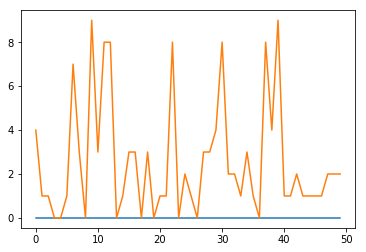

In [31]:
plt.plot(v_max[:50])
plt.plot(p_max[:50])

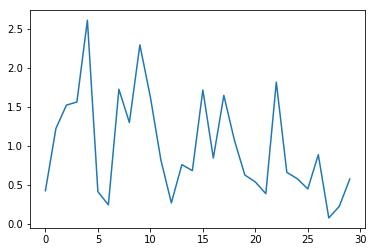

In [17]:
plt.plot(abs(w.get_value()))

In [ ]:
# Construct Theano expression graph
p_1 = 1 / (1 + T.exp(-T.dot(x, w) - b))   # Probability that target = 1
prediction = p_1 > 0.5                    # The prediction thresholded
xent = -y * T.log(p_1) - (1-y) * T.log(1-p_1) # Cross-entropy loss function
cost = xent.mean() + 0.01 * (w ** 2).sum()# The cost to minimize
gw, gb = T.grad(cost, [w, b])             # Compute the gradient of the cost
                                          # w.r.t weight vector w and
                                          # bias term b
                                          # (we shall return to this in a
                                          # following section of this tutorial)

# Compile
train = theano.function(
          inputs=[x,y],
          outputs=[prediction, xent],
          updates=((w, w - 0.1 * gw), (b, b - 0.1 * gb)))
predict = theano.function(inputs=[x], outputs=prediction)

# Train
for i in range(training_steps):
    pred, err = train(D[0], D[1])

print("Final model:")
print(w.get_value())
print(b.get_value())
print("target values for D:")
print(D[1])
print("prediction on D:")
print(predict(D[0]))